## Retrieve data

In [1]:
import os
from collections import Counter
from tqdm import tqdm


data_dir = "/media/aziz/Data/Aziz/data/gans_for_apr/training/"

print("Collecting file paths...")
file_paths = [root+'/'+name for root, dirs, files in tqdm(os.walk(data_dir)) for name in files]
buggy_paths = [f_path for f_path in tqdm(file_paths) if 'buggy' in f_path]
fixed_paths = [f_path for f_path in tqdm(file_paths) if 'fixed' in f_path]

print("Collecting file contents...")
buggy_data = []
for path in tqdm(buggy_paths):
    with open(path, 'r', encoding='utf-8') as f:
        buggy_data.append(f.read())
fixed_data = []
for path in tqdm(fixed_paths):
    with open(path, 'r', encoding='utf-8') as f:
        fixed_data.append(f.read())

print('Number of processed files:-')
print(len(buggy_data), 'buggy files +', len(fixed_data), 'fixed files = ', len(buggy_data)+len(fixed_data), 'files')

5145it [00:00, 51443.79it/s]

21757it [00:00, 64098.48it/s]
 25%|██▍       | 5393/21756 [00:00<00:00, 53924.14it/s]

100%|██████████| 21756/21756 [00:00<00:00, 52285.27it/s]

Number of processed files:-
21756 buggy files + 21756 fixed files =  43512 files


## Clean data - Reduce noise

### Remove comments

In [2]:
import re


def remove_comments(code):
    code = re.sub('(?s)/\*.*?\*/', '', code)
    return re.sub('(//[^\n]*)', '', code)


buggy_no_comments = [remove_comments(x) for x in tqdm(buggy_data)]
fixed_no_comments = [remove_comments(x) for x in tqdm(fixed_data)]
print('Comments have been removed')

100%|██████████| 21756/21756 [00:00<00:00, 114852.27it/s]

Comments have been removed


### Remove unnecessary white spaces

In [3]:
def remove_spaces(code):
    '''This function removes excessive spaces and keeps necessary ones'''
    code = code.splitlines()
    result = []
    for line in code:
        line = line.split()
        line = ' '.join(line)
        if len(line) > 0:  # Remove empty lines
            result.append(line)
    
    return '\n'.join(result)


buggy_no_spaces = [remove_spaces(x) for x in tqdm(buggy_no_comments)]
fixed_no_spaces = [remove_spaces(x) for x in tqdm(fixed_no_comments)]
print('White spaces have been removed')

100%|██████████| 21756/21756 [00:00<00:00, 30573.09it/s]

White spaces have been removed


### Remove identical buggy and fixed codes

In [4]:
buggy_texts, fixed_texts = [], []
for buggy, fixed in zip(buggy_no_spaces, fixed_no_spaces):
    if buggy != fixed:
        buggy_texts.append(buggy)
        fixed_texts.append(fixed)
print(len(buggy_no_spaces)-len(buggy_texts), 'code pairs have been removed')
print('Current # data points:', len(buggy_texts))

4726 code pairs have been removed
Current # data points: 17030


### Remove duplicated pairs in the dataset

In [5]:
text_pairs = [(x, y) for x, y in zip(buggy_texts, fixed_texts)]
code_pairs = sorted(set(text_pairs))  # Sorted to ensure same order every run (not sure if 'set' works randomly)

buggy_codes = [x[0] for x in code_pairs]
fixed_codes = [x[1] for x in code_pairs]

print(len(text_pairs)-len(code_pairs), 'code pairs have been removed')
print('Current # data points:', len(buggy_codes))

3857 code pairs have been removed
Current # data points: 13173


## Calculate Diffs

In [6]:
from difflib import ndiff


initial_diffs = [list(ndiff(x.splitlines(), y.splitlines())) for x, y in tqdm(zip(buggy_codes, fixed_codes))]

13173it [00:03, 3836.07it/s]


### Restrict to one-line difference

In [7]:
one_line_diffs = []
for diff in tqdm(initial_diffs):
    if sum([1 for x in diff if x.startswith('-')]) > 1 or sum([1 for x in diff if x.startswith('+')]) > 1:
        continue
    one_line_diffs.append(diff)

print(len(initial_diffs)-len(one_line_diffs), 'code pairs have been removed')
print('Current # data points:', len(one_line_diffs))

100%|██████████| 13173/13173 [00:00<00:00, 68208.78it/s]

322 code pairs have been removed
Current # data points: 12851


### Restrict to modified lines (exclude added/deleted lines)

In [8]:
diffs = []
for diff in tqdm(one_line_diffs):
    for i, x in enumerate(diff):
        if x.startswith('+') and diff[i-1].startswith('-'):
            diffs.append((diff[i-1][2:], x[2:]))

print(len(one_line_diffs)-len(diffs), 'code pairs have been removed')
print('Current # data points:', len(diffs))

100%|██████████| 12851/12851 [00:00<00:00, 75814.61it/s]

7102 code pairs have been removed
Current # data points: 5749


#### Shuffle and keep only 1000 data points

In [9]:
from random import seed, sample


seed(30)
shuf_diffs = sample(diffs, k=len(diffs))
final_diffs = shuf_diffs[:1000]
train_diffs, test_diffs = final_diffs[:900], final_diffs[900:]

train_buggy_lines = [x[0] for x in train_diffs]
train_fixed_lines = [x[1] for x in train_diffs]

test_buggy_lines = [x[0] for x in test_diffs]
test_fixed_lines = [x[1] for x in test_diffs]

# The Experiment

In [10]:
import javalang


def create_tokenised(code_lines, fixed=False):
    code_streams = [javalang.tokenizer.tokenize(x, ignore_errors=True) for x in code_lines]
    code_tokenised = []
    for code in code_streams:
        code_tokenised.append([x.value for x in code])
    if fixed:
        return [['<sol>']+x+['<eol>'] for x in code_tokenised]
    else:
        return code_tokenised
    

train_buggy_tokenised = create_tokenised(train_buggy_lines)
train_fixed_tokenised = create_tokenised(train_fixed_lines, True)
test_buggy_tokenised = create_tokenised(test_buggy_lines)
test_fixed_tokenised = create_tokenised(test_fixed_lines, True)


print("Before vectorisation:-")
print(train_buggy_lines[2])
print(train_fixed_lines[2])
print("====================")
print("After vectorisation:-")
print(train_buggy_tokenised[2])
print(train_fixed_tokenised[2])

Before vectorisation:-
return Class.forName(className);
return JavaUtils.loadClass(className);
After vectorisation:-
['return', 'Class', '.', 'forName', '(', 'className', ')', ';']
['<sol>', 'return', 'JavaUtils', '.', 'loadClass', '(', 'className', ')', ';', '<eol>']


In [11]:
vocab = set([x for y in train_buggy_tokenised for x in y]+[x for y in train_fixed_tokenised for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [12]:
print(int_token_map)

{1: 'toDOMSource', 2: 'ClientResponse', 3: 'methodSignature', 4: 'serverSessionFrameListener', 5: 'assertThat', 6: 'selector', 7: 'defaultValue', 8: 'f', 9: 'inNamespace', 10: 'isDetached', 11: '"LIKE"', 12: 'isVertexGroup', 13: 'setObjectFileDir', 14: 'cpu', 15: 'dwpt', 16: 'delete', 17: 'numberCounters', 18: 'JobKey', 19: 'clearLibraryCache', 20: 'snapshotSizeSearch', 21: 'Whitebox', 22: 'BUILTIN', 23: 'JAXRXException', 24: 'ObjectCacheFactory', 25: 'createSerializer', 26: 'DDLWork', 27: 'ExecutionConfig', 28: 'work', 29: 'ModuleComponentIdentifier', 30: 'checkNotNull', 31: 'getWriterFactory', 32: 'getLabelAttrs', 33: 'sql', 34: 'attSize', 35: 'ReplStateLogWork', 36: '"src/foo.xoo"', 37: 'metaData', 38: 'mac', 39: '10', 40: '%', 41: 'annotations', 42: 'CreateFileOptions', 43: 'HttpStatus', 44: 'nextBoolean', 45: 'entry', 46: 'earthDiameter', 47: 'fileType', 48: 'dbName', 49: 'SubGraph', 50: 'Decl', 51: 'populateMapRedPlan5', 52: 'host', 53: 'HTML', 54: 'storeTermVector', 55: 'model',

In [13]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in train_buggy_tokenised])
max_fixed_len = max([len(txt) for txt in train_fixed_tokenised])
num_dps = len(train_fixed_tokenised)
num_test_dps = len(test_fixed_tokenised)

# test_buggy_codes = [x for x in test_buggy_codes if len(x) <= max_buggy_len]
# test_fixed_codes = [x for x in test_fixed_codes if len(x) <= max_fixed_len]

In [14]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 900
Vocabulary size: 3095
Max length in buggy codes: 72
Max length in fixed codes: 56


In [15]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(train_buggy_tokenised, train_fixed_tokenised)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.


test_buggy_inputs =  np.zeros((num_test_dps, max_buggy_len), dtype='int32')
test_fixed_inputs =  np.zeros((num_test_dps, max_fixed_len), dtype='int32')

for i, (buggy, fixed) in enumerate(zip(test_buggy_tokenised, test_fixed_tokenised)):
    for t, token in enumerate(buggy):
        if token not in list(token_int_map.keys()):
            test_buggy_inputs[i, t] = token_int_map['<pad/unknown>']
        else:
            test_buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        if token not in list(token_int_map.keys()):
            test_fixed_inputs[i, t] = token_int_map['<pad/unknown>']
        else:
            test_fixed_inputs[i, t] = token_int_map[token]

In [16]:
from keras.layers import Input, Concatenate, Embedding, LSTM, Dense, dot, Activation, concatenate, Lambda
from keras.models import Model
from keras.backend import argmax, cast


def build_discriminator(dimension, v_size, buggy_len, fixed_len):
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    concatted = Concatenate()([buggy_input_layer, fixed_input_layer])
    embed_lay = Embedding(v_size, dimension, mask_zero=True)(concatted)
    x = LSTM(dimension)(embed_lay)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([buggy_input_layer, fixed_input_layer], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension, mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build model
    gen = Model([buggy_input_layer, fixed_input_layer], model_output)
    
    return gen


def build_gan(gen, disc, buggy_len, fixed_len):
    disc.trainable = False
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    gen_out = gen([buggy_input_layer, fixed_input_layer])
    argmax_layer = Lambda(lambda x: cast(argmax(x, axis=2), dtype='float32'))
    disc_out = disc([buggy_input_layer, argmax_layer(gen_out)])
    gan = Model([buggy_input_layer, fixed_input_layer], [disc_out, gen_out])
    # compile model
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1, 100])
    
    return gan

Using TensorFlow backend.


W1014 13:32:19.959777 139719405606656 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1014 13:32:19.970876 139719405606656 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 13:32:19.975291 139719405606656 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 13:32:20.896612 139719405606656 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 72)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 56, 3095)     28394519    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 56)           0           model_2[1][0]                    
__________

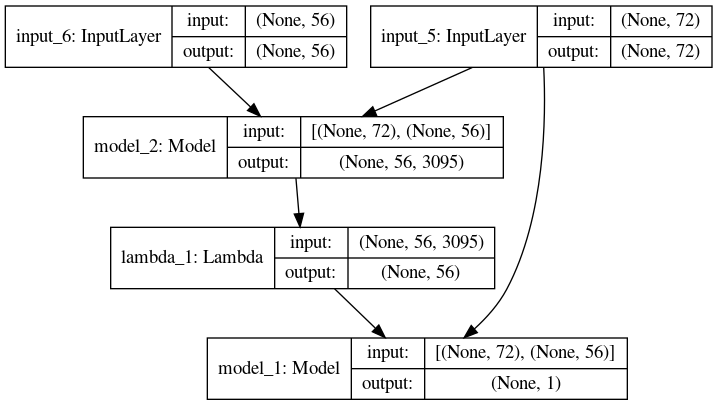

In [17]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

discriminator = build_discriminator(latent_dim, vocab_size, max_buggy_len, max_fixed_len)
plot_model(discriminator, to_file='discriminator_apr.png', show_shapes=True, show_layer_names=True)
# Image('discriminator_model_plot.png')

generator = build_generator(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(generator, to_file='generator_apr.png', show_shapes=True, show_layer_names=True)
# Image('generator_model_plot.png')

gan = build_gan(generator, discriminator, max_buggy_len, max_fixed_len)
plot_model(gan, to_file='gan_model_apr.png', show_shapes=True, show_layer_names=True)
gan.summary()
Image('gan_model_apr.png')

In [18]:
def generate_fixed_ints(gen, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<sol>"]
    for buggy, generated in tqdm(zip(bugs, gntd_ints), total=len(bugs)):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = gen.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eol>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints


def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

In [19]:
import datetime
from tqdm import tqdm


epochs = 30

start_time = datetime.datetime.now().replace(microsecond=0)
for e in range(epochs):
    print('Iteration', str(e+1)+'/'+str(epochs)+':-')
    discriminator.fit([buggy_inputs, fixed_inputs], np.ones(num_dps))
    generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    discriminator.fit([buggy_inputs, generated_ints], np.zeros(num_dps))
    gan.fit([buggy_inputs, fixed_inputs], [np.ones(num_dps), fixed_outputs])
    generated_ints = generate_fixed_ints(generator, test_buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    generated_codes = decode_ints(generated_ints, int_token_map)
    for buggy, fixed, gnrtd in zip(test_buggy_tokenised, test_fixed_tokenised, generated_codes):
        print('Buggy code:', ' '.join(buggy))
        print('---')
        print('Fixed code:', ' '.join(fixed[1:-1]))
        print('Genration: ', ' '.join(gnrtd[1:]))
        print('=============')
        print('=============')
end_time = datetime.datetime.now().replace(microsecond=0)

Iteration 1/30:-


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
900/900 [==============================] - 9s 10ms/step - loss: 0.0243 - acc: 0.9756


100%|██████████| 900/900 [47:18<00:00,  3.22s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 4s - loss: 7.9712 - acc: 0.0000e+00


/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 11s 12ms/step - loss: 549.6814 - model_1_loss: 1.3769e-07 - model_2_loss: 5.4968


100%|██████████| 100/100 [00:42<00:00,  2.67it/s]
/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  = . ( ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  = = . ( ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  . ( ) ;
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  = . ( ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed code: return region . bulkLoadHFiles ( familyPaths ) ;
Genration:  . ( ) ;
Buggy code: count += info . docCount - info . getDelCount ( ) ;


900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [05:42<00:00,  2.89it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 372.3111 - model_1_loss: 1.1921e-07 - model_2_loss: 3.7231


100%|██████████| 100/100 [01:12<00:00,  1.57it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  return new ( ) . class . class . ( ) ) ) ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  return new ( ) ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( new ( ) ) ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  return = new ( . ( ) ) ) ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed code: return region . bulkLoadHFiles ( familyPaths ) ;
Genration:

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [11:11<00:00,  1.69it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 4s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 329.9240 - model_1_loss: 1.1921e-07 - model_2_loss: 3.2992


100%|██████████| 100/100 [05:10<00:00,  3.23s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  this . ( ) . ( ) , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  this . info ( this . new ( ) , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null , null
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ) . ( ) . equals ( ) . equals ( ) . equals

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [45:02<00:00,  2.73s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 4s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 295.1260 - model_1_loss: 1.1921e-07 - model_2_loss: 2.9513


100%|██████████| 100/100 [01:40<00:00,  1.09s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  final final final = new new ( new ( ) . ( ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  final final final = new new ( new ( ) . get ( ) ,
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ! ) . ( ) . ( ) . ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  final final final = new new ( new ( ) . get ( ) ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed 

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [14:43<00:00,  1.28s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 263.8693 - model_1_loss: 1.1921e-07 - model_2_loss: 2.6387


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  return ( ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  throw ( ) . getMessage ( ) ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ! ) && context . equals ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String ( ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed code: return region . bulkLoadHFiles ( familyPaths ) ;
Genration:  return ( ) ) ;
Bug

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [10:12<00:00,  1.02it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 236.6289 - model_1_loss: 1.1921e-07 - model_2_loss: 2.3663


100%|██████████| 100/100 [01:22<00:00,  1.45s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  return new MockAnalyzer ( ) , new ( ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  return new HashMap ( ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ! context . get ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  final final null && null && input . get ( ) && ! ( ) && stats . get ( ) && ! ( ) && clientSessionFrameListener ;
Buggy code: region . bulkLoadHFiles 

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [14:08<00:00,  1.17it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 213.7031 - model_1_loss: 1.1921e-07 - model_2_loss: 2.1370


100%|██████████| 100/100 [01:49<00:00,  1.67s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  super ( regionInfo , null , null , null , null , null ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  throw new HiveException ( e , e , null , null , null , null ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( input . get ( 0 ) . get ( 0 ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String String = new String > > > > > > = new LinkedHashMap < String ) ;
Buggy code

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [15:56<00:00,  1.02it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 7.9712 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 7.9712 - acc: 0.0000e+00
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 187.4203 - model_1_loss: 1.1921e-07 - model_2_loss: 1.8742


100%|██████████| 100/100 [00:54<00:00,  1.34it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  throw new HashMap ( ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  throw new HashMap ( ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ! true ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String 0 = new int ( ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed code: return region . bulkLoadHFiles ( familyPaths ) ;
Genration:  result . debug ( "Data 

900/900 [==============================] - 6s 6ms/step - loss: 5.9605e-08 - acc: 1.0000


100%|██████████| 900/900 [08:37<00:00,  1.61it/s]


Epoch 1/1
900/900 [==============================] - 6s 6ms/step - loss: 2.6015 - acc: 0.6456
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 181.0343 - model_1_loss: 15.6642 - model_2_loss: 1.6537


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  assertEquals ( ] , new String , String ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  return conf , HConstants . LATEST_TIMESTAMP , null ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( context . isNormalServer ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String [ ]
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed code: return region . bulkLoadHF

900/900 [==============================] - 6s 6ms/step - loss: 2.4563 - acc: 0.4322


100%|██████████| 900/900 [12:33<00:00,  1.01it/s]


Epoch 1/1
900/900 [==============================] - 6s 6ms/step - loss: 1.8158 - acc: 0.3978
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 150.6463 - model_1_loss: 6.3325 - model_2_loss: 1.4431


100%|██████████| 100/100 [01:19<00:00,  1.10it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ! new String [ ] ] ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String String = editHelper . getQuartzContextName ( getCamelContext ( ) ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths )

900/900 [==============================] - 6s 6ms/step - loss: 1.1841 - acc: 0.4578


100%|██████████| 900/900 [12:33<00:00,  1.19s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 2.7572 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 1.0731 - acc: 0.4311
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 128.4070 - model_1_loss: 5.0062 - model_2_loss: 1.2340


100%|██████████| 100/100 [01:32<00:00,  1.38s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME , false ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( EndpointHelper . getType ( ) , new String [ ] {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  if ( myTokenType == null , null ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths 

900/900 [==============================] - 6s 6ms/step - loss: 0.9932 - acc: 0.4311


100%|██████████| 900/900 [14:45<00:00,  1.12s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 2.2926 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 0.9271 - acc: 0.4311
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 109.4638 - model_1_loss: 4.2899 - model_2_loss: 1.0517


100%|██████████| 100/100 [02:23<00:00,  2.00s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  TEST_UTIL . loadTable ( ht , COLUMN_FAMILY , false ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . loadTable ( ht , COLUMN_FAMILY , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( context . isNormalServer ( ) == null ? null : null ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node )

900/900 [==============================] - 6s 6ms/step - loss: 0.8796 - acc: 0.4311


100%|██████████| 900/900 [21:43<00:00,  1.89s/it]


Epoch 1/1
900/900 [==============================] - 6s 6ms/step - loss: 0.8463 - acc: 0.4311
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 92.3274 - model_1_loss: 3.8976 - model_2_loss: 0.8843


100%|██████████| 100/100 [01:39<00:00,  1.03s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  TEST_UTIL . loadTable ( table . setAutoFlush ( new Configuration ( conf , conf . valueOf ( charset ) ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . loadTable ( ht , COLUMN_FAMILY , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( EndpointHelper . matchEndpoint ( context . conf . getName ( ) ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String fil

900/900 [==============================] - 6s 6ms/step - loss: 0.8174 - acc: 0.4311


100%|██████████| 900/900 [14:58<00:00,  1.32s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 1.8876 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 0.7925 - acc: 0.4322
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 76.8635 - model_1_loss: 3.6904 - model_2_loss: 0.7317


100%|██████████| 100/100 [02:04<00:00,  1.59s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  TEST_UTIL . createTable ( TableName . valueOf ( TEST_TABLE ) , new MetaStoreThread . BooleanPointer ( ) , new File ( File . separator , e ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . createTable ( TableName . valueOf ( TEST_TABLE ) , new byte ( byte [ ] bytes = new int [ ] { TEST_FAMILY } , 5 ) ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( ! new File ( method . getName ( ) ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterEx

900/900 [==============================] - 6s 6ms/step - loss: 0.7864 - acc: 0.4300


100%|██████████| 900/900 [19:31<00:00,  1.67s/it]


Epoch 1/1
900/900 [==============================] - 6s 6ms/step - loss: 0.7726 - acc: 0.4311
Epoch 1/1
900/900 [==============================] - 9s 9ms/step - loss: 61.6141 - model_1_loss: 3.4617 - model_2_loss: 0.5815


100%|██████████| 100/100 [01:11<00:00,  1.06it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME , false ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( nextSampleIdx <= <= context . maxSize && numFiles minSplits this ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression 

900/900 [==============================] - 6s 6ms/step - loss: 0.7583 - acc: 0.4322


100%|██████████| 900/900 [11:54<00:00,  1.47it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 1.6915 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 0.7456 - acc: 0.4311
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 50.4880 - model_1_loss: 3.3181 - model_2_loss: 0.4717


100%|██████████| 100/100 [01:14<00:00,  1.09it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  termsConsumer . finishTerm ( text , false ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_UTIL . loadTable ( ht , FAMILYNAME , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file != null ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  final detailLevel = NetUtils . long2Mac ( NetUtils . createSequenceBasedMacAddress ( mac , NetworkModel . MACIdentifier > v

900/900 [==============================] - 6s 6ms/step - loss: 0.7379 - acc: 0.4322


100%|██████████| 900/900 [12:31<00:00,  1.01s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 1.5883 - acc: 0.0312

900/900 [==============================] - 6s 6ms/step - loss: 0.7017 - acc: 0.4344
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 41.2912 - model_1_loss: 3.3003 - model_2_loss: 0.3799


100%|██████████| 100/100 [01:19<00:00,  1.01s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  t . setAutoFlush ( false , false ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_MAC , "127.0.0.1" ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  ( column , s ) && plan . getSuccessors ( key ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) 

900/900 [==============================] - 6s 6ms/step - loss: 0.7394 - acc: 0.4333


100%|██████████| 900/900 [12:55<00:00,  1.30it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 1.5610 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 0.7079 - acc: 0.4344
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 34.7718 - model_1_loss: 3.6725 - model_2_loss: 0.3110


100%|██████████| 100/100 [01:19<00:00,  1.07it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  from ( "direct:start" ) . to ( "log:a?level=OFF" , "log:b?level=OFF" , "direct:c" ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  prunerExpr , schemaToMergedSchemaMap , useMultipleSchemas ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file . getPath ( ) . values ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serialize

900/900 [==============================] - 6s 6ms/step - loss: 0.6547 - acc: 0.4811


100%|██████████| 900/900 [12:51<00:00,  1.11it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 2.9491 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 0.7064 - acc: 0.5067
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 30.1525 - model_1_loss: 5.9494 - model_2_loss: 0.2420


100%|██████████| 100/100 [01:18<00:00,  1.07s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  from ( "direct:start" ) , jobId ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  prunerExpr , rowObjectInspector , conf ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file . getPath ( ) == null ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) 

900/900 [==============================] - 6s 6ms/step - loss: 0.7935 - acc: 0.5144


100%|██████████| 900/900 [13:18<00:00,  1.32s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 1.2096 - acc: 0.0000e+00

900/900 [==============================] - 6s 6ms/step - loss: 0.2486 - acc: 0.7344
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 20.1900 - model_1_loss: 0.4386 - model_2_loss: 0.1975


100%|██████████| 100/100 [01:09<00:00,  1.06it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  template . loadTable ( ht , FAMILYNAME , false ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  prunerExpr , rowObjectInspector , conf ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( EndpointHelper . getFamilyCellMap ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkL

900/900 [==============================] - 6s 6ms/step - loss: 0.0640 - acc: 1.0000


100%|██████████| 900/900 [12:32<00:00,  1.11it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0235 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0169 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 17.6232 - model_1_loss: 0.0230 - model_2_loss: 0.1760


100%|██████████| 100/100 [01:09<00:00,  1.08it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  termsConsumer . setFullyReadColumns ( ) ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_MAC , "127.0.0.1" ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file != null ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed code: retu

900/900 [==============================] - 6s 6ms/step - loss: 0.0077 - acc: 1.0000


100%|██████████| 900/900 [12:23<00:00,  1.29s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0105 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0087 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 14.1229 - model_1_loss: 0.0174 - model_2_loss: 0.1411


100%|██████████| 100/100 [01:21<00:00,  1.09s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  assertEquals ( "b b <b>a</b> b <b>a</b> b " , f . length , - 1 ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  setTaskPlan ( currAliasId , currTopOp , op ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file != null && ! hasRefreshToken . equals ( method . getName ( ) ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . seriali

900/900 [==============================] - 6s 6ms/step - loss: 0.0056 - acc: 1.0000


100%|██████████| 900/900 [13:01<00:00,  1.13s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0069 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0063 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 11.6210 - model_1_loss: 0.0093 - model_2_loss: 0.1161


100%|██████████| 100/100 [01:17<00:00,  1.08it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  t . setAutoFlush ( false , true ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  setTaskPlan ( r , currTopOp , op ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( nextSampleIdx < String , String > size ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkLoadHFiles ( familyPa

900/900 [==============================] - 6s 6ms/step - loss: 0.0042 - acc: 1.0000


100%|██████████| 900/900 [13:00<00:00,  1.30s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0053 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0047 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 9.4803 - model_1_loss: 0.0122 - model_2_loss: 0.0947


100%|██████████| 100/100 [01:25<00:00,  1.14s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  t . setAutoFlush ( false , true , null , null , null , false , usePortsFromConf . "KERBEROS" ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  statusdir , usesHcatalog , completedUrl , enablelog , enableJobReconnect , jobType ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file . getPath ( ) . startsWith ( "twitter-search-twitter-find-component:" ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpress

900/900 [==============================] - 6s 6ms/step - loss: 0.0034 - acc: 1.0000


100%|██████████| 900/900 [13:27<00:00,  1.14it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0039 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0038 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 9.0860 - model_1_loss: 0.0121 - model_2_loss: 0.0907


100%|██████████| 100/100 [01:25<00:00,  1.03it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  AkismetUtil = HiveMetaStore . newRetryingHMSHandler ( "hive client" , conf ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  prunerExpr , rowObjectInspector , conf ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( nextSampleIdx . equals ( tokenizer . nextToken ( ) ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpre

900/900 [==============================] - 6s 6ms/step - loss: 0.0029 - acc: 1.0000


100%|██████████| 900/900 [12:48<00:00,  1.13it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0034 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0032 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 8.0537 - model_1_loss: 0.0050 - model_2_loss: 0.0805


100%|██████████| 100/100 [01:22<00:00,  1.04it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  AkismetUtil = HiveMetaStore . newRetryingHMSHandler ( "hive client" , conf , true ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_MAC , "127.0.0.1" ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file . getPath ( ) . startsWith ( "twitter-search-twitter-find-component:" ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities .

900/900 [==============================] - 6s 6ms/step - loss: 0.0024 - acc: 1.0000


100%|██████████| 900/900 [13:21<00:00,  1.12s/it]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0031 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0029 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 6.3158 - model_1_loss: 0.0043 - model_2_loss: 0.0631


100%|██████████| 100/100 [01:23<00:00,  1.62s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  t . setAutoFlush ( false , true ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  prunerExpr , rowObjectInspector , conf ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( nextSampleIdx . info ( this , uri ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkLoadHFiles ( famil

900/900 [==============================] - 6s 6ms/step - loss: 0.0020 - acc: 1.0000


100%|██████████| 900/900 [13:38<00:00,  1.00it/s]


Epoch 1/1
900/900 [==============================] - 6s 6ms/step - loss: 0.0025 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 5.8851 - model_1_loss: 0.0036 - model_2_loss: 0.0588


100%|██████████| 100/100 [01:18<00:00,  1.08it/s]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  t . setAutoFlush ( false , true ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  prunerExpr , rowObjectInspector , conf ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file != null ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Buggy code: region . bulkLoadHFiles ( familyPaths ) ;
---
Fixed co

900/900 [==============================] - 6s 6ms/step - loss: 0.0017 - acc: 1.0000


100%|██████████| 900/900 [12:57<00:00,  1.04it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0021 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0022 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 6.4812 - model_1_loss: 0.0091 - model_2_loss: 0.0647


100%|██████████| 100/100 [01:20<00:00,  1.12s/it]


Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  AkismetUtil = HiveMetaStore . newRetryingHMSHandler ( "hive client" , conf , true ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_MAC , "127.0.0.1" , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( EndpointHelper . matchEndpoint ( context , uri . getUri ( ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializ

900/900 [==============================] - 6s 6ms/step - loss: 0.0015 - acc: 1.0000


100%|██████████| 900/900 [12:45<00:00,  1.04it/s]

Epoch 1/1
 32/900 [>.............................] - ETA: 5s - loss: 0.0021 - acc: 1.0000

900/900 [==============================] - 6s 6ms/step - loss: 0.0019 - acc: 1.0000
Epoch 1/1
900/900 [==============================] - 8s 9ms/step - loss: 5.3506 - model_1_loss: 0.0028 - model_2_loss: 0.0535


100%|██████████| 100/100 [01:17<00:00,  1.11s/it]

Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  AkismetUtil = new DocumentsWriter ( directory , this . conf ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_MAC , "127.0.0.1" , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file . getPath ( ) . startsWith ( endpointNormalized + File . separator ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpress

In [20]:
print("Training took (h:mm:ss)", end_time-start_time)

Training took (h:mm:ss) 8:37:43


In [21]:
generated_ints = generate_fixed_ints(generator, test_buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(test_buggy_tokenised, test_fixed_tokenised, generated_codes):
    print('Buggy code:', ' '.join(buggy))
    print('---')
    print('Fixed code:', ' '.join(fixed[1:-1]))
    print('Genration: ', ' '.join(gnrtd[1:]))
    print('=============')
    print('=============')

100%|██████████| 100/100 [01:17<00:00,  1.12s/it]

Buggy code: createDataset ( "whom" , KeyValueTable . class ) ;
---
Fixed code: createDataset ( "whom" , KeyValueTable . class , DatasetProperties . builder ( ) . setDescription ( "Store names" ) . build ( ) ) ;
Genration:  AkismetUtil = new DocumentsWriter ( directory , this . conf ) ;
Buggy code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent ) ;
---
Fixed code: GradleLauncher newInstance ( StartParameter startParameter , ServiceRegistry parent , boolean newSession ) ;
Genration:  TEST_MAC , "127.0.0.1" , false ) ;
Buggy code: if ( this . length < newLength ) {
---
Fixed code: if ( this . bytes . length < newLength ) {
Genration:  if ( file . getPath ( ) . startsWith ( endpointNormalized + File . separator ) ) {
Buggy code: String filterExpr = Utilities . serializeExpression ( node ) ;
---
Fixed code: String filterExpr = SerializationUtilities . serializeExpression ( node ) ;
Genration:  String filterExpr = SerializationUtilities . serializeExpress